# Sparkify Project

**Project Overview:** In this project, a digital music service named Sparkify similar to Spotfiy or Pandora is set up with user data. Spark will be used to manipulate the customer data to perform data exploratory analysis, and build a predictive machine learning model of the customer churn in the Spark big-data framework. 

If companies are able to utilize customer-usage data and find patterns in them and map them accurately to indicate which customers might churn, they could, in principle, incentivize customers to stay with them. Finding such patterns could also be useful from the perspective of targeted advertising - customers demographics with advantageous average behavior can be targeted for advertising with hopes of better returns than blanket advertising.


**Project Purpose:** Churn prevention is a hot and challenging problem in almost every product and service company. If the risk of users disconnecting service could be predicted, then company could take actions to save customers before they leaving. In this sepecific case for Sparkify, what I do is to predict users at risk to cancel their services or downgrading from premium to free tier altogether. More sepecifically, I will use the monthly user-product interations along with user demographic information to predict next month churn. If we could get good model performance and make it into production, company would benefit a lot.

**Project Evaluation:** Since customer churn or not is a binary outcome, the classification models will be built on the processed dataset. Churn or stay group is imblanced, F1 score, AUC score will be as the evalution metrics inteading of accuracy.

# Table of Content

Target: Predict users at risk to churn either downgrade from premium to free tier or cancelling their services altogether.

1. Load and Clean Dataset
2. Feature Engineering.
3. Build Data Processing and ML Pipeline.
4. Model Training and Prediction.

#### Import Necessary Libraries

In [5]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, isnan, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc, countDistinct, expr, min, max
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType, StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, Normalizer, MinMaxScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Create a SparkSession for using spark and name it "Sparkify".

In [6]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
The following steps will be processed with subset of a 12GB dataset named `mini_sparkify_event_data.json`. First of all the dataset the dataset will be loaded, cleaned and checked for invalid or missing data.

In [7]:
# Read json data
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [8]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# Select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','level' ,'location','method','page']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

In [10]:
# Check for null values 
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [11]:
# Total sessions after removing duplicates based on user and session id
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [12]:
# Total number of sessions after removing blank user id 
df = df.filter(df["userId"] != "")
df.count()

278154

In [13]:
# Number of unique users in dataset
user_ids = df.select('userId').dropDuplicates().count()
print('The number of unique users in dataset: ' + str(user_ids))

# Number of unique session ids
session_ids = df.select('sessionId').dropDuplicates().count()
print('The number of unique session ids: ' + str(session_ids))

# Number of unique pages
pages = df.select('page').dropDuplicates().count()
print('The number of unique pages: ' + str(pages))

The number of unique users in dataset: 225
The number of unique session ids: 2312
The number of unique pages: 19


# Exploratory Data Analysis (EDA)
To gain first insights about the dataset, an exploratory data analysis is conducted to observe the behavior for users who stayed vs users who churned. Once we have done some preliminary analysis, we define churn in the project context and create a column `Churn` to use it as label for modeling.

In [14]:
# Churn Definition (1 = cancel, 0 = paid)
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

In [15]:
# Create a user defined function for formating the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
# Apply the udf on the ts column
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='8')

In [16]:
df_pandas = df.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,8
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,9
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,9
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,9
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,9


In [17]:
# Count number of songs played in hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
# Create pandas for songs played in hour
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.head()

,hour,count
0,0,8142
1,1,8154
2,2,8043
3,3,8184
4,4,8360


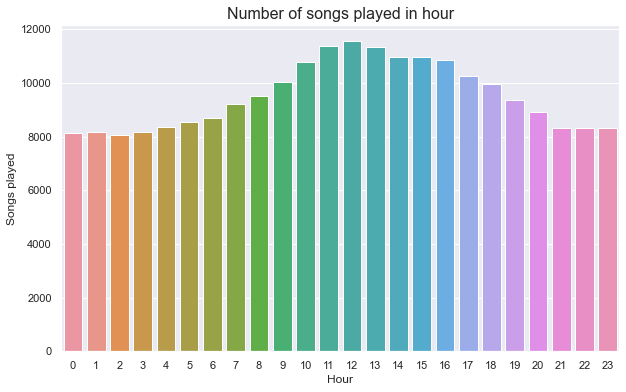

In [18]:
# Songs played in hour
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Number of songs played in hour", fontsize= 16)
sns.barplot(x="hour", y="count", data= songs_in_hour_pd)
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [19]:
# Distribution of users by Churn Type
churn_count = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_count_pd = churn_count.toPandas() # Create churn count dataframe

Text(0, 0.5, 'Number of Users')

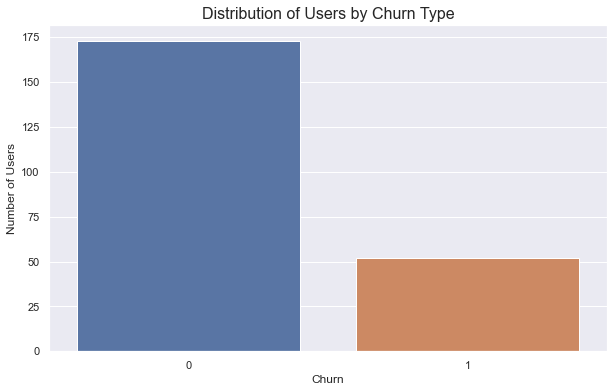

In [20]:
# Distribution of users by Churn Type Plot
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Distribution of Users by Churn Type", fontsize= 16)
sns.barplot(x='Churn', y='Users', data= churn_count_pd)
plt.xlabel("Churn")
plt.ylabel("Number of Users")

In [21]:
# Churn per gender
print('Churn per gender')
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

print('Non-churn per gender')
df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

Churn per gender
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

Non-churn per gender
+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [22]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd, nonchurn_gender_pd], sort=False, ignore_index=True)
churn_gender.head()

,gender,count,Churn
0,F,20,True
1,M,32,True
2,F,104,False
3,M,121,False


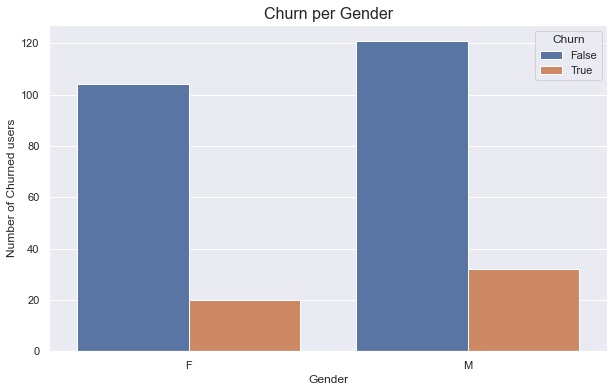

In [23]:
# Plot churn per gender
plt.figure(figsize=(10, 6))
plt.title('Churn per Gender', fontsize=16)
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.show()

### Page Distribution 
- The most popular user activity are nextsong, thumbs up, and home.

In [39]:
# All user activity types
pages = df.groupby('page').count().sort('count', ascending=False)
pages.show()
pages_df = pages.toPandas()

activity = pages_df['page']
count = pages_df['count']

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



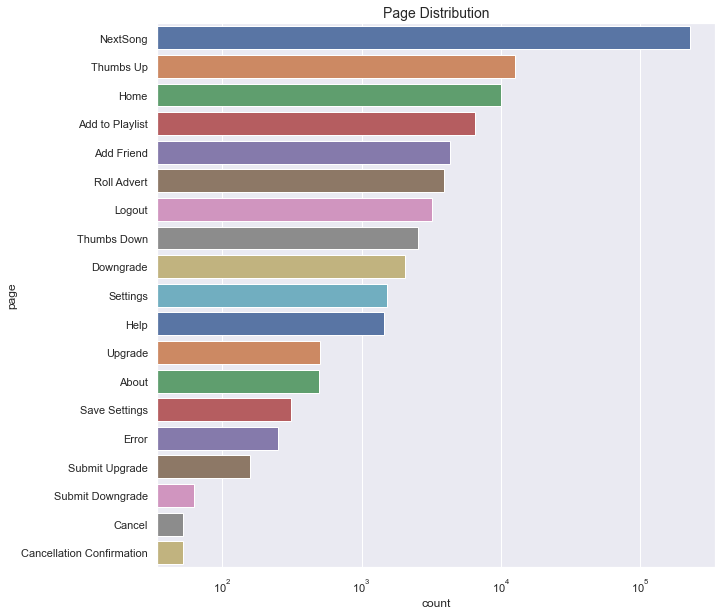

In [33]:
current_palette = sns.color_palette()
plt.figure(figsize=(10, 10))

sns.barplot(x=count,
            y=activity,
            log=True,
            palette=current_palette)
plt.title("Page Distribution", fontsize=14);

In [40]:
# Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlsparkify")

In [46]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   df_sqlsparkify
                    GROUP BY page,
                             churn
                    """).toPandas()

In [51]:
page_churn_df.head()

,page,churn,total_user
0,Settings,0,152
1,Thumbs Down,1,48
2,Thumbs Up,1,50
3,Add to Playlist,1,50
4,Error,1,22


In [76]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):
    """
    Similar to sns.barplot but added text option for the bar
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.loc[:,x].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height /data.loc[:,y].sum() * 100 :.2f}%",
                            ha="center", fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height :.2f}",
                            ha="center", fontsize=8)

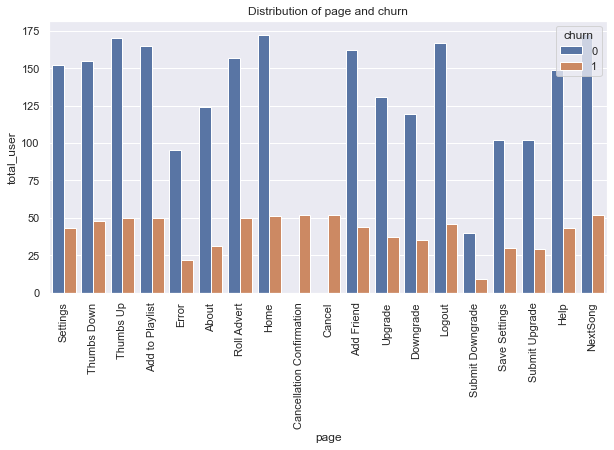

In [78]:
sns_barplot_text(x="page", y="total_user", data=page_churn_df, hue="churn",
                 title="Distribution of page and churn", percentage=False,
                 text=False, figsize=(10, 5))

In [62]:
# Create DataFrame for total user in location
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   df_sqlsparkify
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [63]:
# Create DataFrame for churn user in location
location_churn_df = spark.sql("""
                                 SELECT location, 
                                        Count(DISTINCT userid) AS churn_user 
                                 FROM   df_sqlsparkify
                                 WHERE  churn=1
                                 GROUP BY location
                                 """).toPandas()

In [64]:
# Merge DataFrame and add percentage column
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
38,"Flint, MI",2,2,100.0
18,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
29,"Quincy, IL-MO",1,1,100.0
0,"Cleveland-Elyria, OH",1,1,100.0
20,"Monroe, LA",1,1,100.0
27,"North Wilkesboro, NC",1,1,100.0
23,"Bozeman, MT",1,1,100.0
21,"Little Rock-North Little Rock-Conway, AR",1,1,100.0
17,"Memphis, TN-MS-AR",1,1,100.0
32,"Lexington-Fayette, KY",1,1,100.0


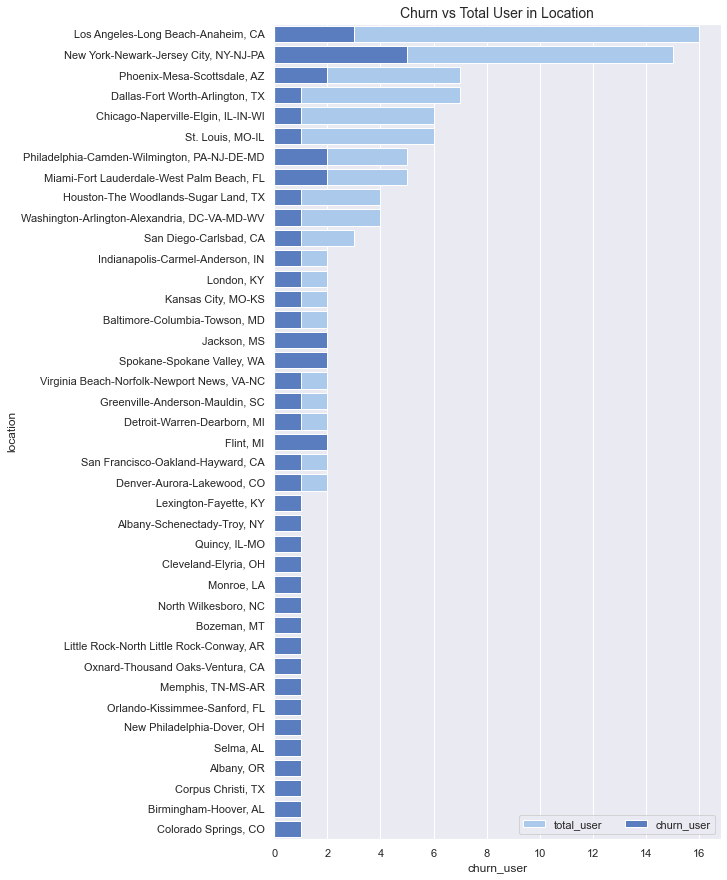

In [65]:
fig, ax = plt.subplots(figsize=(8, 15))
plt.title("Churn vs Total User in Location", fontsize=14)
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax, 
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

# Feature Engineering

Now that we've familiarized ourselves with the data set, we try to find and build promising features to train the model on.

### Feature Creation

The following Features will be creted at user level:

1.  avg_session_duration: average session duration [float]
2.  churn: "1" for a page cancellation confirmation (defined as churn), "0" for absence of churn [binary]
3.  gender: "1" for male, "0" for female [binary]
4.  length: total length of songs listened [float]
5.  level: latest level of a user. "1" for paid, "0" for free [binary]
6.  location: location of the user [binary]
7.  page: number visits per page [int]
8.  time_since_reg: time since registration [int]
9.  sessions: total number of sessions [int]
10. songs: total number of songs listend [int]
11. userAgent: agents used by the user [binary]

In [66]:
# Load small subset for feature engineering
df = spark.read.json('mini_sparkify_event_data.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

#### 1.  avg_session_duration

In [67]:
# Create Feature
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



#### 2.  churn

In [68]:
# User definded function
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Create feature
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
# Validation
print('Number of rows: ' + str(churn.count()))
churn.show(5)

Number of rows: 225
+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



#### 3.  gender

In [69]:
# User definded function
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Create feature
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))

# Validation
print('Number of rows: ' + str(gender.count()))
gender.show(5)

Number of rows: 225
+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



#### 4.  length

In [70]:
# Create feature for total time 
length = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')

print('Number of rows: ' + str(length.count()))
length.show(5)

Number of rows: 225
+------+------------------+
|userId|        total_time|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



#### 5.  level

In [71]:
# User definded function
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Create feature
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

# Validation
print('Number of rows: ' + str(level.count()))
level.show(5)

Number of rows: 225
+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



#### 6.  location

In [72]:
# User definded function
get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
get_location_name = udf(lambda x: "location_"+x.replace(" ", "_").lower())

# Create feature
location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location']).dropDuplicates(['userId'])\
           .groupBy('userId').pivot('location').agg(count('location')).fillna(0)

# Validation
print('Number of rows: ' + str(location.count()))
location.show(5)

TypeError: 'Series' object is not callable

#### 7.  page

In [ ]:
# User definded function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation']

# Create feature
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

# Validation
print('Number of rows: ' + str(page.count()))
page.show(5)

#### 8.  time_since_reg

In [ ]:
# Create feature
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

# Validation
print('Number of rows: ' + str(time_since_reg.count()))
time_since_reg.show(5)

#### 9.  sessions

In [30]:
# Create feature
sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

# Validation
print('Number of rows: ' + str(sessions.count()))
sessions.show(5)

Number of rows: 225
+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
+------+--------+
only showing top 5 rows



#### 10. songs

In [31]:
# Create feature
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

# Validation
print('Number of rows: ' + str(songs.count()))
songs.show(5)

Number of rows: 225
+------+-----+
|userId|songs|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows



#### 11. userAgent

In [32]:
# User definded function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

# Validation
print('Number of rows: ' + str(userAgent.count()))
userAgent.show(5)

Number of rows: 225
+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|100010|        0|      0|  0|         0|   0|     1|
|200002|        0|      0|  0|         0|   0|     1|
|   125|        1|      0|  0|         0|   0|     0|
|   124|        1|      0|  0|         0|   0|     0|
|    51|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



### Merge Features

Bring together all built features.

In [33]:
df = churn.join(avg_session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(location, ['userId'])\
          .join(page, ['userId'])\
          .join(time_since_reg, ['userId'])\
          .join(sessions, ['userId'])\
          .join(songs, ['userId'])\
          .join(userAgent, ['userId'])

In [34]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- AK: long (nullable = true)
 |-- AL: long (nullable = true)
 |-- AR: long (nullable = true)
 |-- AZ: long (nullable = true)
 |-- CA: long (nullable = true)
 |-- CO: long (nullable = true)
 |-- CT: long (nullable = true)
 |-- DC: long (nullable = true)
 |-- FL: long (nullable = true)
 |-- GA: long (nullable = true)
 |-- IA: long (nullable = true)
 |-- IL: long (nullable = true)
 |-- IN: long (nullable = true)
 |-- KY: long (nullable = true)
 |-- LA: long (nullable = true)
 |-- MA: long (nullable = true)
 |-- MD: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- MN: long (nullable = true)
 |-- MO: long (nullable = true)
 |-- MS: long (nullable = true)
 |-- MT: long (nullable = true)
 |-- NC: long (nullable = true)
 |-- NE: lon

# Modeling

In [35]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- AK: long (nullable = true)
 |-- AL: long (nullable = true)
 |-- AR: long (nullable = true)
 |-- AZ: long (nullable = true)
 |-- CA: long (nullable = true)
 |-- CO: long (nullable = true)
 |-- CT: long (nullable = true)
 |-- DC: long (nullable = true)
 |-- FL: long (nullable = true)
 |-- GA: long (nullable = true)
 |-- IA: long (nullable = true)
 |-- IL: long (nullable = true)
 |-- IN: long (nullable = true)
 |-- KY: long (nullable = true)
 |-- LA: long (nullable = true)
 |-- MA: long (nullable = true)
 |-- MD: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- MN: long (nullable = true)
 |-- MO: long (nullable = true)
 |-- MS: long (nullable = true)
 |-- MT: long (nullable = true)
 |-- NC: long (nullable = true)
 |-- NE: lon

In [36]:
print((df.count(), len(df.columns)))

(3176, 73)


In [37]:
user_df = df.drop('userId')
#user_df.write.save("user_df.csv",format = "csv",header = True)
features = [col for col in user_df.columns if col!='churn'] 
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [38]:
def model_pipeline(classifier, params):
    """
    Build model pipline 
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [39]:
# logistic regression 
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [40]:
fit_model_lr = model_lr.fit(train)

In [41]:
pred_lr = fit_model_lr.transform(test)

In [42]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))

f1 using Logistic Regression: 0.9603759284935328


In [43]:
#random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [44]:
fit_model_rf = model_rf.fit(train)

In [45]:
pred_rf = fit_model_rf.transform(test)

In [46]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(f1_score_rf))

f1 using Random Forest: 0.8733446068167118


In [47]:
# gradient boost
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [48]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [49]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(gbt_f1_score))

f1 using Gradient Boosting: 0.9827984908109864


In [50]:
# Decision Tree
dt =DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [51]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [52]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(dt_f1_score))

f1 using Gradient Boosting: 0.9302100350802716


## Model Tuning

In [56]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
model_tuned = model_pipeline(lr, paramGrid_lr)

In [57]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [58]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1 using tuned RF: {}".format(best_f1_score))

f1 using tuned RF: 0.9121167317110557


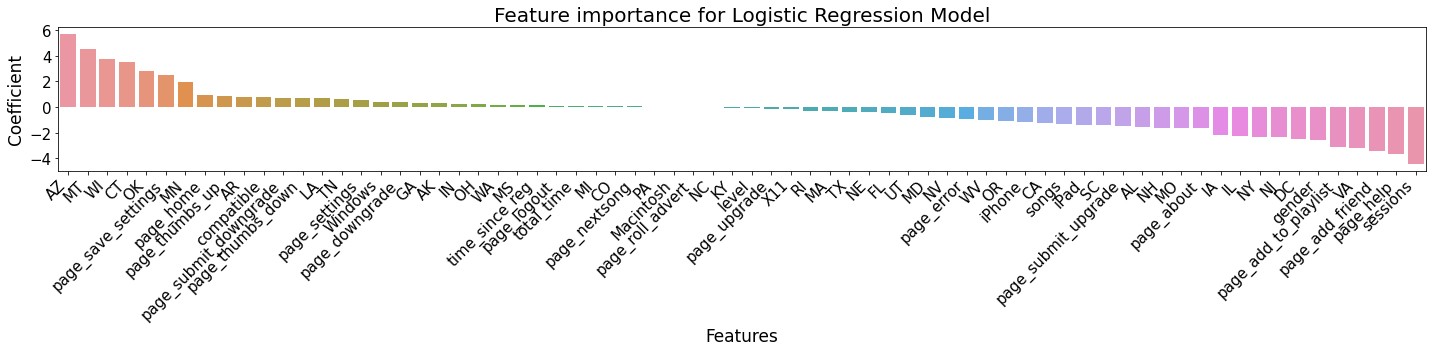

In [59]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

In [ ]:

feat_cols = ['total_artist', 'gender', 'level', 'num_downgrade', 'num_advert', 'num_song_playlist',
     'num_thumbs_down', 'num_thumbs_up', 'num_friend', 'total_length', 'num_song',
     'session', 'avg_songs', 'avg_daily_sessions', 'avg_monthly_sessions', 'os',
     'browser', 'browser_ver']

### Conclusion

Out of the 4 tested models, the Gradient Boosting Tree classifier shows up the best prediction performance with a F1 score of 0.98.